In [1]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_pickle('C:/Users/sgogr/Desktop/TYBSc ASA Sem VI/Project/pickels/28k_apparel_data')

# find number of products that have duplicate titles.
print(sum(data.duplicated('title')))

data.head()

# Data Preprocessing

In [ ]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

In [ ]:
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

In [ ]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [ ]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]
print('Number of data points : ', data.shape[0])
data.to_pickle('pickels/17k_apperal_data')

In [ ]:
data = pd.read_pickle('C:/Users/sgogr/Desktop/TYBSc ASA Sem VI/Project/pickels/17k_apperal_data')

In [ ]:
indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [ ]:
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]
print('Number of data points after stage two of dedupe: ',data.shape[0])
data.to_pickle('C:/Users/sgogr/Desktop/TYBSc ASA Sem VI/Project/pickels/16k_apperal_data')

In [ ]:
data = pd.read_pickle('C:/Users/sgogr/Desktop/TYBSc ASA Sem VI/Project/pickels/16k_apperal_data')

# Text-Preprocessing of Titles

In [ ]:
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

In [ ]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

In [ ]:
data.head()
data.to_pickle('C:/Users/sgogr/Desktop/TYBSc ASA Sem VI/Project/pickels/16k_apperal_data_preprocessed')

# Feature Based Recommendation

In [2]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle
import urllib3

Using TensorFlow backend.


In [4]:
data = pd.read_pickle('C:/Users/sgogr/Desktop/TYBSc ASA Sem VI/Project/pickels/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [ ]:
x = data['asin']
a = x.to_frame()
for i in range(16401):
    x=a['https://images-na.ssl-images-amazon.com/images/I/31VspXbakvL._SL160_.jpg'].loc[i]
    urllib.request.urlretrieve(x, "C:/Users/sgogr/Desktop/TYBSc ASA Sem VI/Project/Images/"+str(data['asin'].iloc[i])+".jpg")

In [ ]:
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'C:/Users/sgogr/Desktop/TYBSc ASA Sem VI/Project/'
nb_train_samples = 10
epochs = 50
batch_size = 1


def save_bottlebeck_features():
    asins = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    for i in generator.filenames:
        asins.append(i[2:-5])

    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))
    
    np.save(open('C:/Users/sgogr/Desktop/TYBSc ASA Sem VI/Project/16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)
    np.save(open('C:/Users/sgogr/Desktop/TYBSc ASA Sem VI/Project/16k_data_cnn_feature_asins.npy', 'wb'), np.array(asins))
    
save_bottlebeck_features()

In [3]:
bottleneck_features_train = np.load('C:/Users/sgogr/Desktop/TYBSc ASA Sem VI/Project/16k_data_cnn_features.npy')
asins = np.load('C:/Users/sgogr/Desktop/TYBSc ASA Sem VI/Project/16k_data_cnn_feature_asins.npy')

In [4]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])
asins = list(asins)

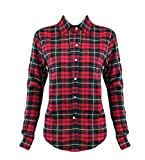

Brand: Ro Rox
Product Title:  ro rox womens gingham festival long sleeve lumberjack shirt us 2 red blue  yellow 
Eucliden Distance from the given image : 4.862804e-06
Amazon Url: www.amzon.com/dp/B00THPW4VM


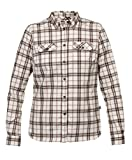

Brand: Fjallraven
Product Title:  fjallraven  womens fjallglim stretch shirt longsleeve chalk white xs 
Eucliden Distance from the given image : 39.876083
Amazon Url: www.amzon.com/dp/B073RTHZRC


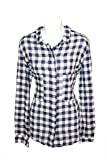

Brand: Comme Toi
Product Title:  comme toi woven long sleeve gingham shirt large 
Eucliden Distance from the given image : 40.69966
Amazon Url: www.amzon.com/dp/B00YFS2OLG


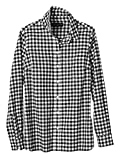

Brand: Banana Republic
Product Title:  banana republic womens classic fit plaid flannel shirt black size small 
Eucliden Distance from the given image : 42.661137
Amazon Url: www.amzon.com/dp/B01N34O7GZ


In [37]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo

def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title','brand']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Brand:', row['brand'])
            print('Product Title: ', row['title'])
            print('Eucliden Distance from the given image :', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

get_similar_products_cnn(4000, 4)

# Text Based Recommendation

In [7]:
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    plot_heatmap(keys, values, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()

(16042, 12609)

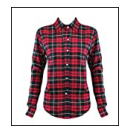

Brand: Ro Rox
Title: ro rox womens gingham festival long sleeve lumberjack shirt us 2 red blue  yellow 
Eucliden Distance from the given image : 0.0
Amazon Url: www.amzon.com/dp/B00THPW4VM


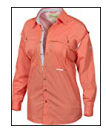

Brand: Drake
Title: womens wingshooter long sleeve shirt 
Eucliden Distance from the given image : 3.1622776601683795
Amazon Url: www.amzon.com/dp/B01BNWY6CQ


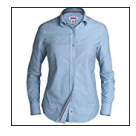

Brand: Boast
Title: womens oxford shirt  long sleeve 
Eucliden Distance from the given image : 3.1622776601683795
Amazon Url: www.amzon.com/dp/B01577JZOC


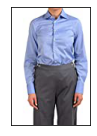

Brand: DSQUARED2
Title: dsquared2 blue long sleeve womens button shirt us xs 38 
Eucliden Distance from the given image : 3.3166247903554
Amazon Url: www.amzon.com/dp/B072KVZ8HK


In [9]:
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Eucliden Distance from the given image :', pdists[i])
        print('Amazon Url: www.amzon.com/dp/'+ data['asin'].loc[df_indices[i]])

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(4000, 4)

In [6]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
tfidf_title_features.get_shape()

(16042, 12609)

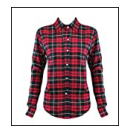

BRAND : Ro Rox
Title: ro rox womens gingham festival long sleeve lumberjack shirt us 2 red blue  yellow 
Eucliden Distance from the given image : 0.0
Amazon Url: www.amzon.com/dp/B00THPW4VM


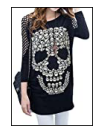

BRAND : Ro Rox
Title: ro rox womens gothic punk womens big skull top one size us 28 black 
Eucliden Distance from the given image : 1.1335581591081625
Amazon Url: www.amzon.com/dp/B00VOE195Q


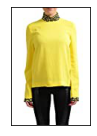

BRAND : Just Cavalli
Title: cavalli womens bright yellow turtleneck long sleeve shirt top us 40 
Eucliden Distance from the given image : 1.2412650589265959
Amazon Url: www.amzon.com/dp/B01C5UJI5U


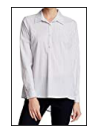

BRAND : Rode
Title: ro  de womens large hilow striped button shirt blue l 
Eucliden Distance from the given image : 1.2420124131041148
Amazon Url: www.amzon.com/dp/B01N7K7XIA


In [48]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Eucliden Distance from the given image :', pdists[i])
        print('Amazon Url: www.amzon.com/dp/'+ data['asin'].loc[df_indices[i]])
        
tfidf_model(4000, 4)